In [5]:
import math
import pickle
import numpy as np
import pandas as pd
from numpy.linalg import inv,pinv
import matplotlib.pyplot as plt
import sys
from IPython import display
import time
%matplotlib inline

__author__ = 'Kiks'

def triM(*args):
    startM=args[0]
    for m in args[1:]:
        startM=startM.dot(m)
    return startM

def getX_min(x_row,o_row,timeD):
    xn1=x_row[0]+o_row[1]*math.cos(x_row[2])*timeD
    yn1=x_row[1]+o_row[1]*math.sin(x_row[2])*timeD
    thet1=x_row[2]+o_row[2]*timeD
    return np.array([xn1,yn1,thet1])
def getHfun(curX,lanX):
    v=math.sqrt((curX[0]-lanX[0])**2+(curX[1]-lanX[1])**2)
    w=math.atan2(lanX[1]-curX[1],lanX[0]-curX[0])-curX[2]
    return np.array([v,w])

def getH(curX,lanX,Hfun):
    VpoX=(curX[0]-lanX[0])/(Hfun[0])
    VpoY=(curX[1]-lanX[1])/(Hfun[0])
    denWder=( (lanX[0]-curX[0])**2 +(lanX[1]-curX[1])**2 )
    
    WpoX=(lanX[1]-curX[1])/denWder
    WpoY=-(lanX[0]-curX[0])/denWder
    
    WpoTh=-1
    return np.array([ [VpoX,VpoY,0],[WpoX,WpoY,-1] ])
    
def getA(x_row,o_row,timeD):
    a=np.eye(3,3)
    a[0,2]=-o_row[1]*math.sin(x_row[2])*timeD
    a[1,2]=o_row[1]*math.cos(x_row[2])*timeD
    return a
def getP_min(AK,PK_1,QK):
    return triM(AK,PK_1,AK.T) + \
    (QK)

def getK(PK_,HK,RK):
    return triM(PK_,HK.T,
           inv(  triM(HK,PK_,HK.T)
                   +RK))

def getX_post(x_row,KK,z_row,h_row):
    return x_row+triM(KK,(z_row-h_row))

def getP(I,KK,HK,PK_):
    return  (I- np.dot(KK,HK)).dot(PK_)
def absdist(x1,x2):
    return abs(x1[0]-x2[0])+abs(x1[1]-x2[1])

def getbaseX(groun,odom):
    if len(odom)<1:
        print('no ground baseX')
        sys.exit(-5)
    fin=np.where(groun[:,0]<=odom[0,0])[0]
    if len(fin)<1:
        print("no baseX for first odom")
        sys.exit(-5)
        #return getbaseX(groun,odom[1:])
    return fin[-1]

In [6]:

def process(groun,odom,meas,btwn_Ms,lanDik,isCorrect=True):
    fInd1=getbaseX(groun,odom)
    print(fInd1)
    #sys.exit(-6)
    
    xCalc=np.zeros((odom.shape[0]+1,odom.shape[1]),dtype=float)
    xCalc[0]=groun[fInd1,1:]
    curTime=groun[fInd1,0]
    
    xTime=np.zeros((odom.shape[0]+1,),dtype=float)
    xTime[0]=curTime
    
    startInd=0
    lenM=len(meas)
    # PMat=np.zeros((odom.shape[0]+1,odom.shape[1]),dtype=float)
    PMat=np.zeros((3,3),dtype=float)

    QMat=np.eye(3,dtype=float)*1e-5
    RMat=np.eye(2)*1e-1
    HMat=np.eye(3)
    IMat=np.eye(3,3)

    postEd=np.zeros((odom.shape[0]+1,),dtype=int)
    postEd[0]=1
    for i,mind in enumerate(np.array(btwn_Ms,dtype=int)):
        for insInd in range(startInd,startInd+mind):
            timeD=odom[insInd,0]-curTime
            xCalc[insInd+1]=getX_min(xCalc[insInd],odom[insInd],timeD)
            xTime[insInd+1]=odom[insInd,0]
            
            curA=getA(xCalc[insInd+1],odom[insInd],timeD)
            PMat=getP_min(curA,PMat,QMat)

            curTime=odom[insInd,0]
        startInd+=mind
        
        if isCorrect and mind!=0 and i<lenM and  int(meas[i][1]) in lanDik:
            postEd[startInd]=1
            #print(startInd,xCalc[startInd],PMat)
            
            hFun=getHfun(xCalc[startInd],lanDik[ int(meas[i][1]) ])
            HMat=getH(xCalc[startInd],lanDik[ int(meas[i][1])],hFun)
            
            try:
                KMat=getK(PMat,HMat,RMat)
            except:
                print(i)
                sys.exit(-10)
            
            
            xCalc[startInd]=getX_post(xCalc[startInd],KMat,
                                      meas[i][2:],hFun)           
            #print("\n============\n",getK(PMat,HMat,RMat))
            PMat=getP(IMat,KMat,HMat,PMat)
            
            #print('\n\n===================\n',
            #      startInd,xCalc[startInd],KMat,PMat,HMat,hFun,meas[i,:],meas[i][2:]-hFun)
            #sys.exit(-20)
            
    return postEd,xCalc,xTime,fInd1

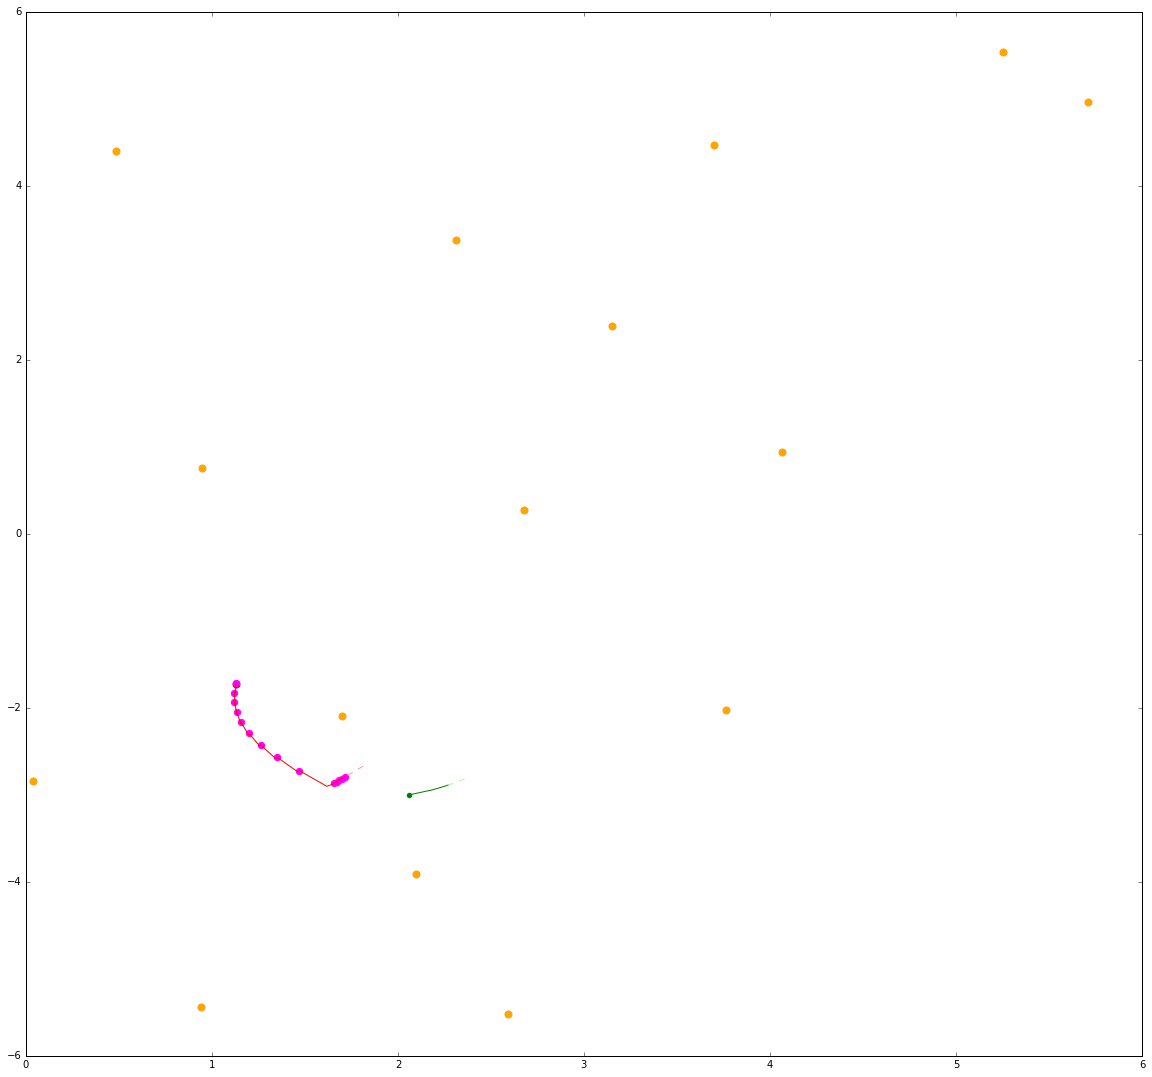

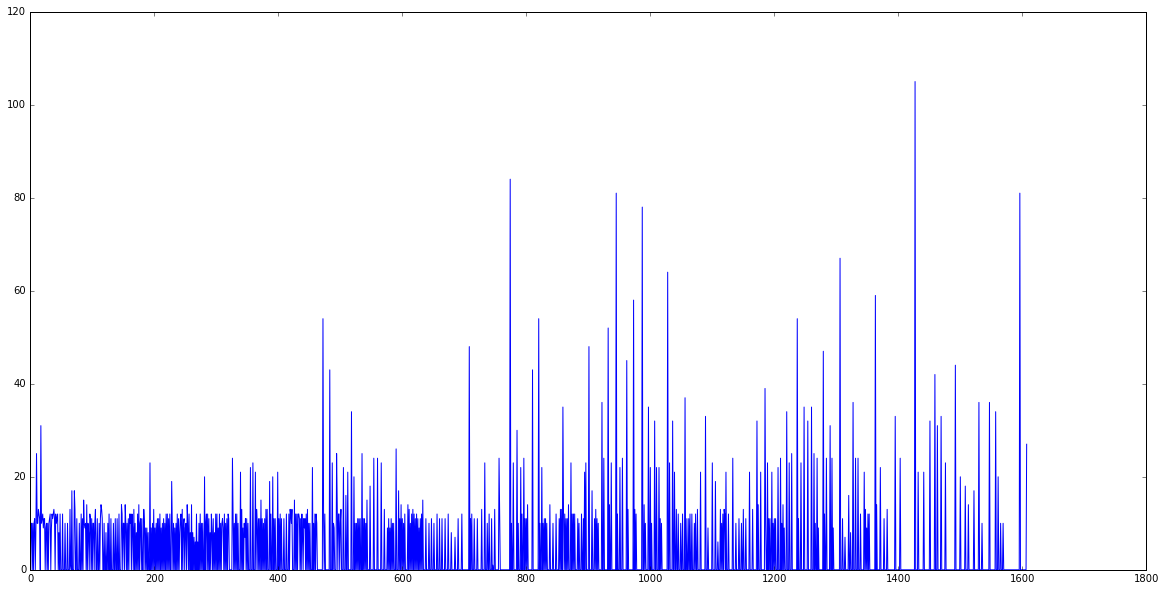

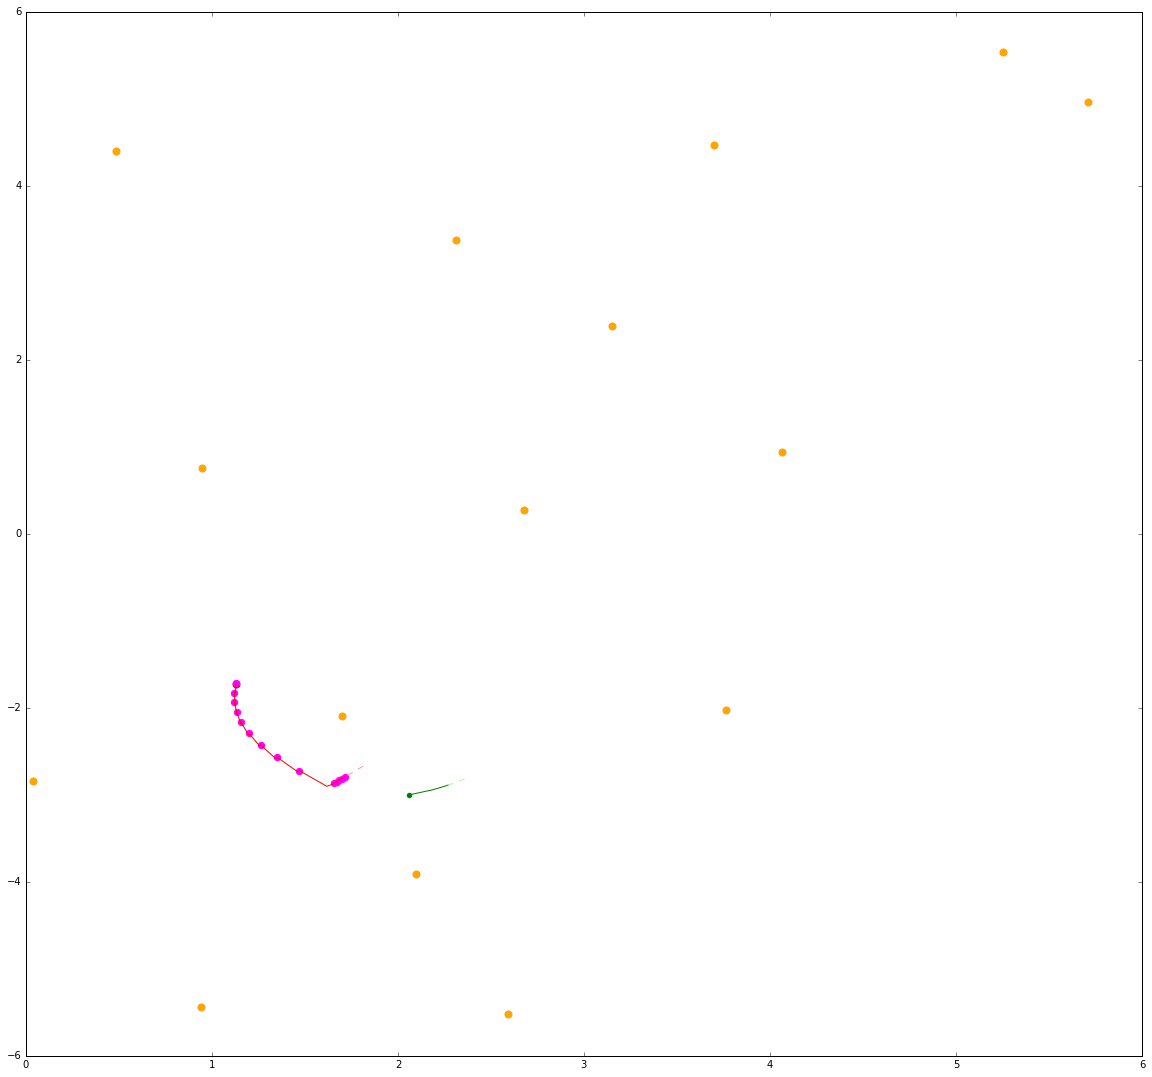

In [23]:
i=3

oName='datasets/Robot{}_Odometry.dat'.format(i)
mName='datasets/Robot{}_Measurement.dat'.format(i)
gName='datasets/Robot{}_Groundtruth.dat'.format(i)
lName='datasets/Landmark_Groundtruth.dat'
bName='datasets/Barcodes.dat'

namesOdom="Time[s]    forward_velocity[m/s]    angular_velocity[rad/s]".split()
odom=pd.read_csv(oName,sep=r"\s*",skiprows=4,names=namesOdom,engine='python')

namesMeas="Time[s]    Subject_#    range[m]    bearing[rad]".split()
meas=pd.read_csv(mName,sep=r"\s*",skiprows=4,names=namesMeas,engine='python')

namesGroun="Time[s]    x[m]    y[m]    orientation[rad]".split()
groun=pd.read_csv(gName,sep=r"\s*",skiprows=4,names=namesGroun,engine='python')

namesLand=" Subject#    x[m]    y[m]    xstd-dev[m]    ystd-dev[m]".split()
land=pd.read_csv(lName,sep=r"\s*",skiprows=4,names=namesLand,engine='python')

namesBar=" Subject#    Barcode#".split()
bar=pd.read_csv(bName,sep=r"\s*",skiprows=4,names=namesBar,engine='python')

odom=np.array(odom.values)
meas=np.array(meas.values)
groun=np.array(groun.values)
land=np.array(land.values)
bar=np.array(bar.values)

print(len(meas),len(set(meas[:,0])))

barDik={int(row[0]):int(row[1]) for row in bar}
landDik={barDik[int(row[0])]:row[1:3] for row in land}

with open('betw_{}.meas'.format(i),"rb") as f:
    bt_Ms,abt_Ms=pickle.load(f)

with open('betw_{}.groun'.format(i),"rb") as f:
    bt_Gt=pickle.load(f)

print(landDik)

startI=0
startO=sum(abt_Ms[:startI])
print(startI,sum(abt_Ms[startI:]),len(odom[startO:]),len(abt_Ms),len(meas))
plt.figure(figsize=(20,10))

plt.plot(abt_Ms[7135:])

postEd,xCalc,xTime,fInd=process(groun,odom[startO:],meas[startI:],
                                abt_Ms[startI:],landDik)
postEdO,xCalcO,xTimeO,fIndO=process(groun,odom[startO:],meas[startI:],
                                abt_Ms[startI:],landDik,False)
plotAll(groun,xCalc,xTime,postEd,200,len(groun),[[-1,6],[-6.5,6.5]],
            xCalcO)

ERROR! Session/line number was not unique in database. History logging moved to new session 212


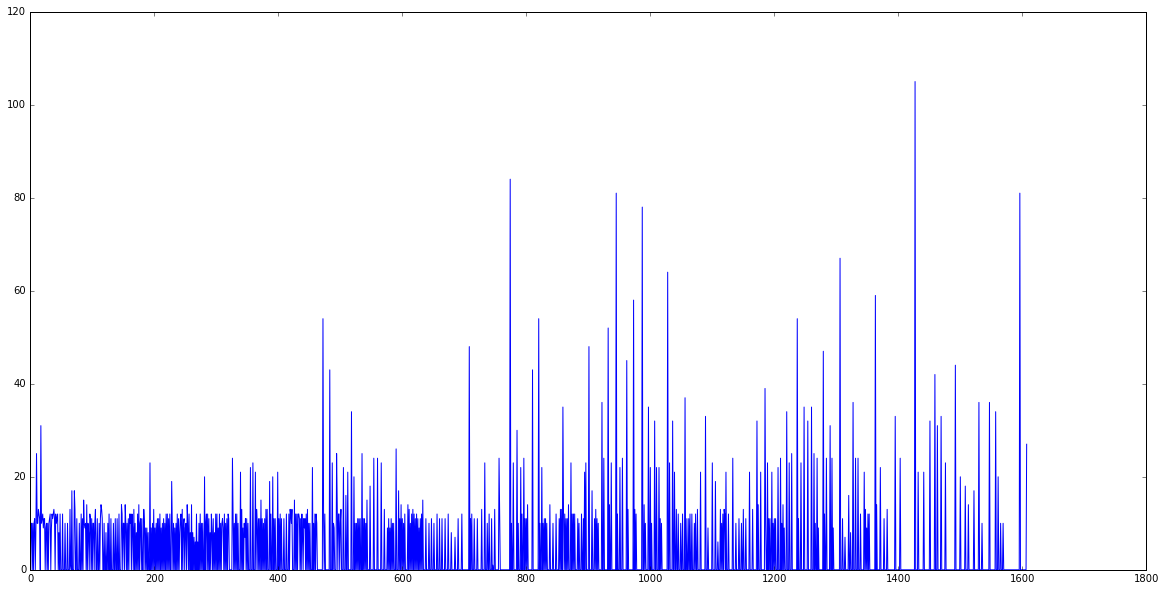

In [18]:
def plotMov(oldG,newG,oldO,newO,oldOO=None,newOO=None):
    #print(oldG.shape,newG.shape,oldO.shape,newO.shape)
    #sys.exit(-5)
    plt.plot(oldG[:,1],oldG[:,2],color=(0.5647,0.933,0.5647,0.7058),linestyle='--')
    plt.plot(newG[:,1],newG[:,2],'g-')
    plt.scatter(newG[-1,1],newG[-1,2],color='green',s=20)
    
    plt.plot(oldO[:,0],oldO[:,1],color= (1.0, 0.6, 0.6),linestyle='--')
    if oldOO!= None: plt.plot(oldOO[:,0],oldOO[:,1],
                              color= (1.0,165/255,0),linestyle='--')
    # magenta where it actually is posted + final dot
    if len(newO)>0:
        koiC=np.where(newO[:,4]>0.0)[0]
        
        plt.scatter(newO[-1,0],newO[-1,1],color='red',s=50)
        plt.scatter(newO[koiC,0],newO[koiC,1],color='magenta',s=40)      
        
        
    plt.plot(newO[:,0],newO[:,1],'r-')
    if newOO!= None: plt.plot(newOO[:,0],newOO[:,1],
                              color= (1.0,165/255,0))
def plotLand(lanList):
    plt.scatter(lanList[:,0],lanList[:,1],color='orange',s=50)

In [14]:
def plotAll(groun,xCalc,xTime,postEd,stepRun,maxgrounH,xyAxes,
            xCalcO=None):
    maxgrounH=60000
    #timeTh=groun[grounH,0]
    oldG=0
    upper=20
    lower=-20
    print("shapes xcalc and xtime and posted",xCalc.shape,xTime.shape,postEd.shape)

    grounS=groun[fInd:]
    lanList=np.array(list(landDik.values()))

    xCalc2=np.clip(xCalc,lower,upper)
    xCalc3=np.vstack((xCalc2.T,xTime,postEd)).T
    
    np.clip(xCalcO,lower,upper,xCalcO)
    xCalcO=np.vstack((xCalcO.T,xTime,postEd)).T
    oldpXO=np.zeros((0,2))
    
    print(xCalc3.shape)
    p1xCalc=xCalc3#[np.where(postEd==1)]
    print(p1xCalc[:5,4]==1.0)
    oldpX=np.zeros((0,2))
    oldPlotG=np.zeros((0,3))

    #p2xCalc=p1xCalc[p1xCalc[:,3]<timeTh,:]
    sites=[]

    plt.figure(figsize=(20,20))
    plt.subplots_adjust(top=0.85)
    axes=plt.gca()
    axes.set_xlim(xyAxes[0])
    axes.set_ylim(xyAxes[1])
    #plt.subplot(211)
    #plt.plot(np.array(p1xCalc[:,3]<timeTh,dtype=int)[:5])
    for ind,i in enumerate(range(50,maxgrounH,stepRun)):
        if ind%1==0: 
            plt.clf()
            axes=plt.gca()
            axes.set_xlim([0,6])
            axes.set_ylim([-6,6])
        grounH=i
        print('     \r',grounH,end='',flush=True)
        timeTh=grounS[grounH,0]
        timeThp=grounS[oldG,0]
        p3xCalc=p1xCalc[(p1xCalc[:,3]<=timeTh) & (p1xCalc[:,3]>timeThp),:]
        pxCalcO=xCalcO[(p1xCalc[:,3]<=timeTh) & (p1xCalc[:,3]>timeThp),:]
        
        gBatch=grounS[oldG:grounH,:]

        oldG=i
        print(p3xCalc.shape)
        plotMov(oldPlotG,gBatch,oldpX,p3xCalc,oldpXO,pxCalcO)
        plotLand(lanList)

        sites.append([oldG,grounH,timeThp,timeTh,len(p3xCalc)])
        
        oldpX=p3xCalc
        oldpXO=pxCalcO
        
        oldPlotG=gBatch

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(1.5)

    #print (sites)
    sites=np.array(sites)

ERROR! Session/line number was not unique in database. History logging moved to new session 210


54.8647746244


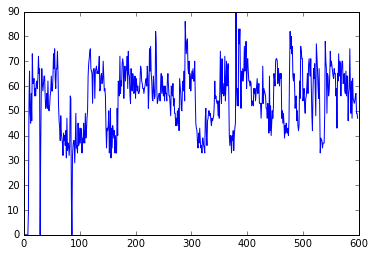

In [38]:
np.set_printoptions(precision=12)
#print(groun[:50*20:50,0].reshape((20,1)))
#np.hstack((sites[:20,2:4],groun[:50*20:50,0].reshape((20,1))))
plt.plot(sites[:,4])
print(np.average(sites[:,4]))

In [ ]:
howMuch=sum(postEd==1)
upper=6
lower=-4
cutoffSpike=0.05

pxCalc=xCalc[np.where(postEd==1)]
# pxCalc=pxCalc[  (pxCalc[:,0]<upper) & (pxCalc[:,0]>lower) &
# (pxCalc[:,1]<upper) & (pxCalc[:,1]>lower)]
p1xCalc=np.clip(pxCalc,lower,upper)
pgroun=groun[ np.where(moe>0) ]
print(len(pgroun),len(p1xCalc))

pmoe=np.array(moe[fInd:])
pmoe=pmoe[pmoe>0]

p2xCalc=[abs(a[0]-b[0])+abs(a[1]-b[1]) for a,b in zip(p1xCalc[:-1],p1xCalc[1:])  ]
p3xCalc=np.zeros(p1xCalc.shape)
old=p1xCalc[0]
# p2xCalc.insert(0,0)
for ind,(x1,x2) in enumerate(zip(p1xCalc,p1xCalc[1:])):
    if absdist(x1,old)>1:
        p3xCalc[ind]=old
    else:
        old=x1
        sind=ind
        p3xCalc[ind]=x1
        
print (len(pmoe),len(p2xCalc))
print("Differences smaller than {}:".format(cutoffSpike), 
      sum(np.array([absdist(a,(b[1],b[2]))
    for a,b in zip(p1xCalc[1:],pgroun)])<cutoffSpike)/len(pgroun))

In [21]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(top=0.85)
plt.subplot(212)
plt.plot(p1xCalc[:howMuch,0],p1xCalc[:howMuch,1],'r-')
plt.plot(pgroun[:howMuch,1],pgroun[:howMuch,2],'g-')

plt.subplot(211)
plt.title("Comparison of groundtruth and odometry-\n corrected by "
   +"groundtruth(groundtruth in green)\nFirst {0}/{1} examples shown".format(howMuch,len(pxCalc)))

plt.plot(pgroun[:howMuch,1],pgroun[:howMuch,2],'g-')
plt.plot(p1xCalc[:howMuch,0],p1xCalc[:howMuch,1],'r-')


In [23]:
plt.figure(figsize=(20,10))
plt.title("Absolute Difference between groundtruth\n and odometry-corrected")
plt.plot([absdist(a,(b[1],b[2])) for a,b in zip(p1xCalc[1:],pgroun)])

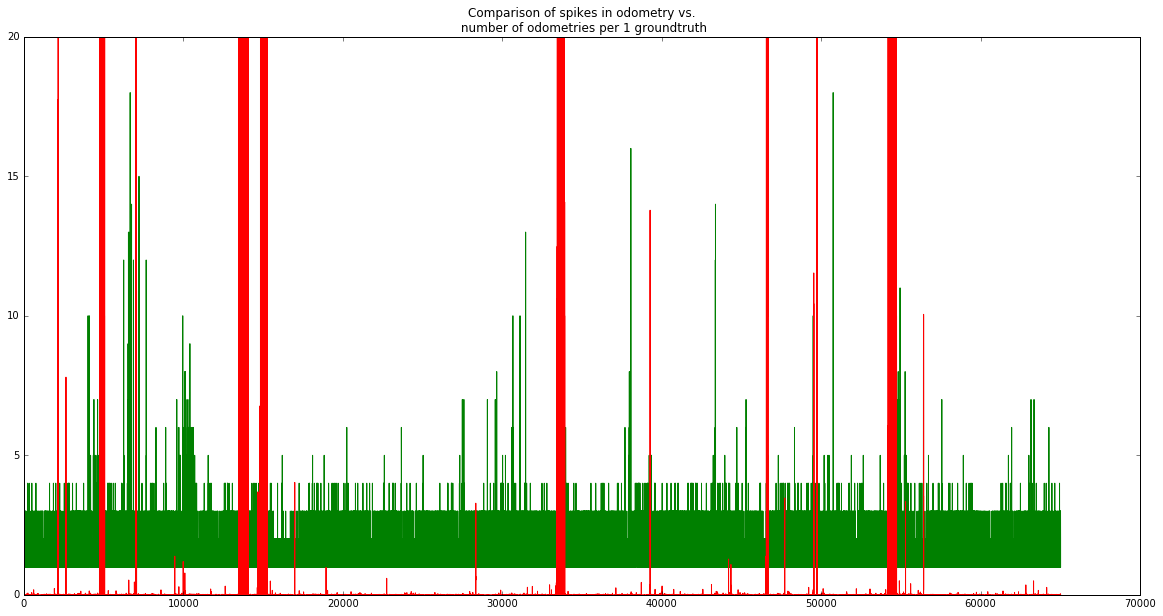

In [25]:
plt.figure(figsize=(20,10))
plt.title("Comparison of spikes in odometry vs.\n number of odometries per 1 groundtruth")
# plt.subplot(211)
plt.plot(pmoe,'g-')
plt.plot(p2xCalc,'r-')

In [7]:
np.zeros((3,3))
np.array([ [1,2,0],[3,4,-1] ])

array([[ 1,  2,  0],
       [ 3,  4, -1]])

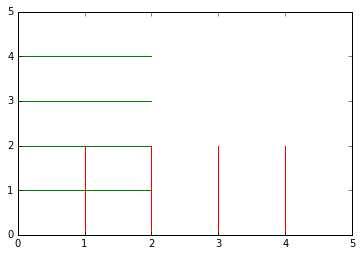

In [79]:
from IPython import display
import time
for i in range(6):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.plot(np.arange(3),np.ones((3,))*i,'g-')
    plt.plot(np.ones((3,))*i,np.arange(3),'r-')
    
    time.sleep(0.1)

In [11]:
curX=[3,5,math.pi]
lanX=[5,3]
print(getHfun(curX,lanX))
print(-math.pi+0.5404)

[ 2.82842712 -2.60117315]
-2.601192653589793
